In [24]:
# # !pip install -r requirements.txt
# !pip install --upgrade jax jaxlib
# !pip install --upgrade equinox # Add this line to upgrade equinox
# !pip install -U "datasets>=2.19.0"
!pip install --upgrade "jax[cuda12]==0.6.0" jax-cuda12-plugin==0.6.0
#           └─ installs jaxlib 0.6.0 automatically
!pip install equinox

In [25]:
import jax
print(jax.devices())          # should list at least one GPU
print(jax.default_backend())  # should say 'gpu'


[CudaDevice(id=0)]
gpu


In [26]:
import os

target_dir = "/content/drive/MyDrive/ConDiff-main"

os.makedirs(target_dir, exist_ok=True)

os.chdir(target_dir)

print("Текущая рабочая директория:", os.getcwd())


Текущая рабочая директория: /content/drive/MyDrive/ConDiff-main


In [27]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import sys
import optax
import equinox as eqx
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython import display
from functools import partial
from jax.lax import scan, dot_general
from load_ConDiff import load_ConDiff
from architectures import UNet
from jax import config, random, grad, vmap, jit
from jax.tree_util import tree_map, tree_flatten

# config.update("jax_enable_x64", True)

# os.environ["CUDA_VISIBLE_DEVICES"] = '0'

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [29]:
def compute_relative_error(model, features, targets, n):
    prediction = vmap(lambda x: model(x), in_axes=(0,))(features[n])
    relative_error = jnp.linalg.norm((prediction - targets[n]).reshape(n.size, -1), axis=1) / jnp.linalg.norm(targets[n].reshape(n.size, -1), axis=1)
    return relative_error

def train_on_epoch(key, batch_size, model, features, targets, opt_state, make_step):
    N_samples = len(features)
    list_of_indices = jnp.linspace(0, N_samples-1, N_samples, dtype=jnp.int64)
    n_batches = N_samples // batch_size
    carry = [model, features, targets, opt_state]
    n = random.choice(key, list_of_indices, shape = (n_batches, batch_size))
    data, epoch_loss = scan(make_step, carry, n)
    model = data[0]
    opt_state = data[-1]
    return epoch_loss, model, opt_state

def test_on_epoch(key, batch_size, model, features, targets):
    N_samples_test = features.shape[0]
    list_of_indices_test = jnp.linspace(0, N_samples_test-1, N_samples_test, dtype=jnp.int64)
    n_batches_test = N_samples_test // batch_size
    n_test = random.choice(key, list_of_indices_test, shape = (n_batches_test, batch_size))
    loss_test_error = lambda a, ind: (None, UNet.compute_loss(model, features[ind], targets[ind]))
    _, test_loss = scan(loss_test_error, None, n_test)
    return jnp.mean(test_loss)

In [30]:
def get_UNet(key, features, grid):
    input = features[0]
    D = len(input.shape[1:])

    input_shape = input.shape[0]
    N_convs = 4
    N_features_out = 1
    kernel_size = 3

    if grid <= 64:
        N_features = 32
    else:
        N_features = grid // 2

    model = UNet.UNet(D, input.shape[1], [input_shape, N_features, N_features_out], kernel_size, N_convs, key, depth=3)

    N_epoch = 400

    if grid <= 64:
        batch_size = 16
    else:
        batch_size = 1024 // grid

    learning_rate = 1e-3

    model_data = {
        "model": model
        }

    optimization_specification = {
        "learning_rate": learning_rate,
        "compute_loss": lambda model, features, targets: UNet.compute_loss(model, features, targets),
        "make_step": lambda carry, indices, optim: UNet.make_step(carry, indices, optim),
        "N_epochs": N_epoch,
        "batch_size": batch_size
    }
    return model_data, optimization_specification

In [31]:
def train_model(model_data, features, targets, optimization_specification):
    model = model_data['model']

    history_train = []
    history_test = []

    features_train, features_test = features[0], features[1]
    targets_train, targets_test = targets[0], targets[1]

    c = features_train.shape[0] // optimization_specification['batch_size']
    keys = tree_map(lambda x: x * c, np.arange(50, 1000, 50))
    values = [0.5, ] * len(keys)
    dict_lr = dict(zip(keys, values))

    sc = optax.piecewise_constant_schedule(optimization_specification['learning_rate'], dict_lr)
    optimizer = optax.adamw(sc, weight_decay=1e-2)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    make_step = lambda x, y: optimization_specification['make_step'](x, y, optimizer)

    for it in tqdm(range(optimization_specification['N_epochs'])):
        key = random.PRNGKey(it)
        loss, model, opt_state = train_on_epoch(key, optimization_specification['batch_size'], model, features_train, targets_train, opt_state, make_step)
        history_train.append(jnp.mean(loss))

        test_loss = test_on_epoch(key, optimization_specification['batch_size'], model, features_test, targets_test)
        history_test.append(test_loss)

    return model, history_train, history_test

def get_datasets(direction_to_save, type_of_pde, grid):
    train_dataset, test_dataset = load_ConDiff(save_dir=direction_to_save,
                                               pde=type_of_pde,
                                               grid=grid)

    features_train = tree_map(lambda x: x.reshape(-1, grid, grid), train_dataset[0])
    targets_train = tree_map(lambda x: x.reshape(-1, grid, grid), train_dataset[1])

    features_test = tree_map(lambda x: x.reshape(-1, grid, grid), test_dataset[0])
    targets_test = tree_map(lambda x: x.reshape(-1, grid, grid), test_dataset[1])

    return [jnp.expand_dims(features_train, 1), jnp.expand_dims(targets_train, 1)], \
           [jnp.expand_dims(features_test, 1), jnp.expand_dims(targets_test, 1)]

In [32]:
def get_results(key, direction_to_save, type_of_pde, grid):
    keys = random.split(key, 3)

    train_dataset, test_dataset = get_datasets(direction_to_save, type_of_pde, grid)
    features_train, targets_train = train_dataset[0], train_dataset[1]
    features_test, targets_test = test_dataset[0], test_dataset[1]

    model_data, optimization_specification = get_UNet(keys[0], features_train, grid)

    features = [features_train, features_test]
    targets = [targets_train, targets_test]

    model, history_train, history_test = train_model(model_data, features, targets,
                                                 optimization_specification=optimization_specification)

    N_samples_train = features_train.shape[0]
    list_of_indices_train = jnp.linspace(0, N_samples_train-1, N_samples_train, dtype=jnp.int64)
    n_batches_train = N_samples_train // optimization_specification['batch_size']
    n_train = random.choice(keys[1], list_of_indices_train, shape = (n_batches_train, optimization_specification['batch_size']))

    N_samples_test = features_test.shape[0]
    list_of_indices_test = jnp.linspace(0, N_samples_test-1, N_samples_test, dtype=jnp.int64)
    n_batches_test = N_samples_test // optimization_specification['batch_size']
    n_test = random.choice(keys[2], list_of_indices_test, shape = (n_batches_test, optimization_specification['batch_size']))

    loss_train_error = lambda a, x: (None, compute_relative_error(model, features_train, targets_train, x))
    _, train_loss_error = scan(loss_train_error, None, n_train)
    train_error_mean = jnp.mean(train_loss_error.reshape(-1,))

    loss_test_error = lambda a, x: (None, compute_relative_error(model, features_test, targets_test, x))
    _, test_loss_error = scan(loss_test_error, None, n_test)
    test_error_mean = jnp.mean(test_loss_error.reshape(-1,))

    train_error_std = jnp.sqrt(jnp.var(test_loss_error.reshape(-1,)))
    test_error_std = jnp.sqrt(jnp.var(test_loss_error.reshape(-1,)))

    model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))

    data = {
        'history_train': history_train,
        'history_test': history_test,
        'train_error_mean': train_error_mean,
        'test_error_mean': test_error_mean,
        'train_error_std': train_error_std,
        'test_error_std': test_error_std,
        'model_size': model_size
    }
    return data, model, model_data, features_test, targets_test

In [33]:
key = random.PRNGKey(22)

grid = 64
type_of_pde = 'poisson'
direction_to_save = "data"

data, model, model_data, features_test, targets_test = get_results(key, direction_to_save, type_of_pde, grid)

100%|██████████| 400/400 [20:47<00:00,  3.12s/it]


In [ ]:
import pickle, hashlib, equinox as eqx, jax.numpy as jnp
from jax.tree_util import tree_flatten


def sha_model(m):
    flat, _ = tree_flatten(eqx.filter(m, eqx.is_array))
    buf = jnp.concatenate([jnp.ravel(a) for a in flat]).tobytes()
    return hashlib.md5(buf).hexdigest()

checkpoint = {
    "model"        : model,
    "features_test": features_test,
    "targets_test" : targets_test,
    "metrics"      : data,
    "model_hash"   : sha_model(model)
}

with open("unet_poisson_checkpoint.pkl", "wb") as f:
    pickle.dump(checkpoint, f)
print("Checkpoint saved")


Checkpoint saved


In [7]:
def plot_results(model, model_data, data, features_test, targets_test):
    prediction = vmap(lambda x: model(x), in_axes=(0,))(features_test)[:, 0]

    display.clear_output(wait=True)

    plt.rcParams['font.family'] = 'serif'
    fig, ax = plt.subplots(1, len(prediction[0].shape)+1, figsize=((len(prediction[0].shape)+1)*5, 4))

    ax[0].set_title(r'Loss', fontsize="15")
    ax[0].set_yscale('log')
    ax[0].set_xlabel(r'# its.')
    ax[0].plot(data['history_train'], linestyle='-', color='red', label='train')
    ax[0].plot(data['history_test'], linestyle='-.', color='green', label='test')
    ax[0].legend(loc='best', fontsize="12")
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['left'].set_visible(True)
    ax[0].spines['right'].set_visible(False)
    ax[0].grid(linestyle='-.')

    ax[1].contourf(prediction[0])
    ax[1].set_title(r'Prediction')

    ax[2].contourf(targets_test[0, 0])
    ax[2].set_title(r'Target')

    plt.tight_layout()
    plt.show()

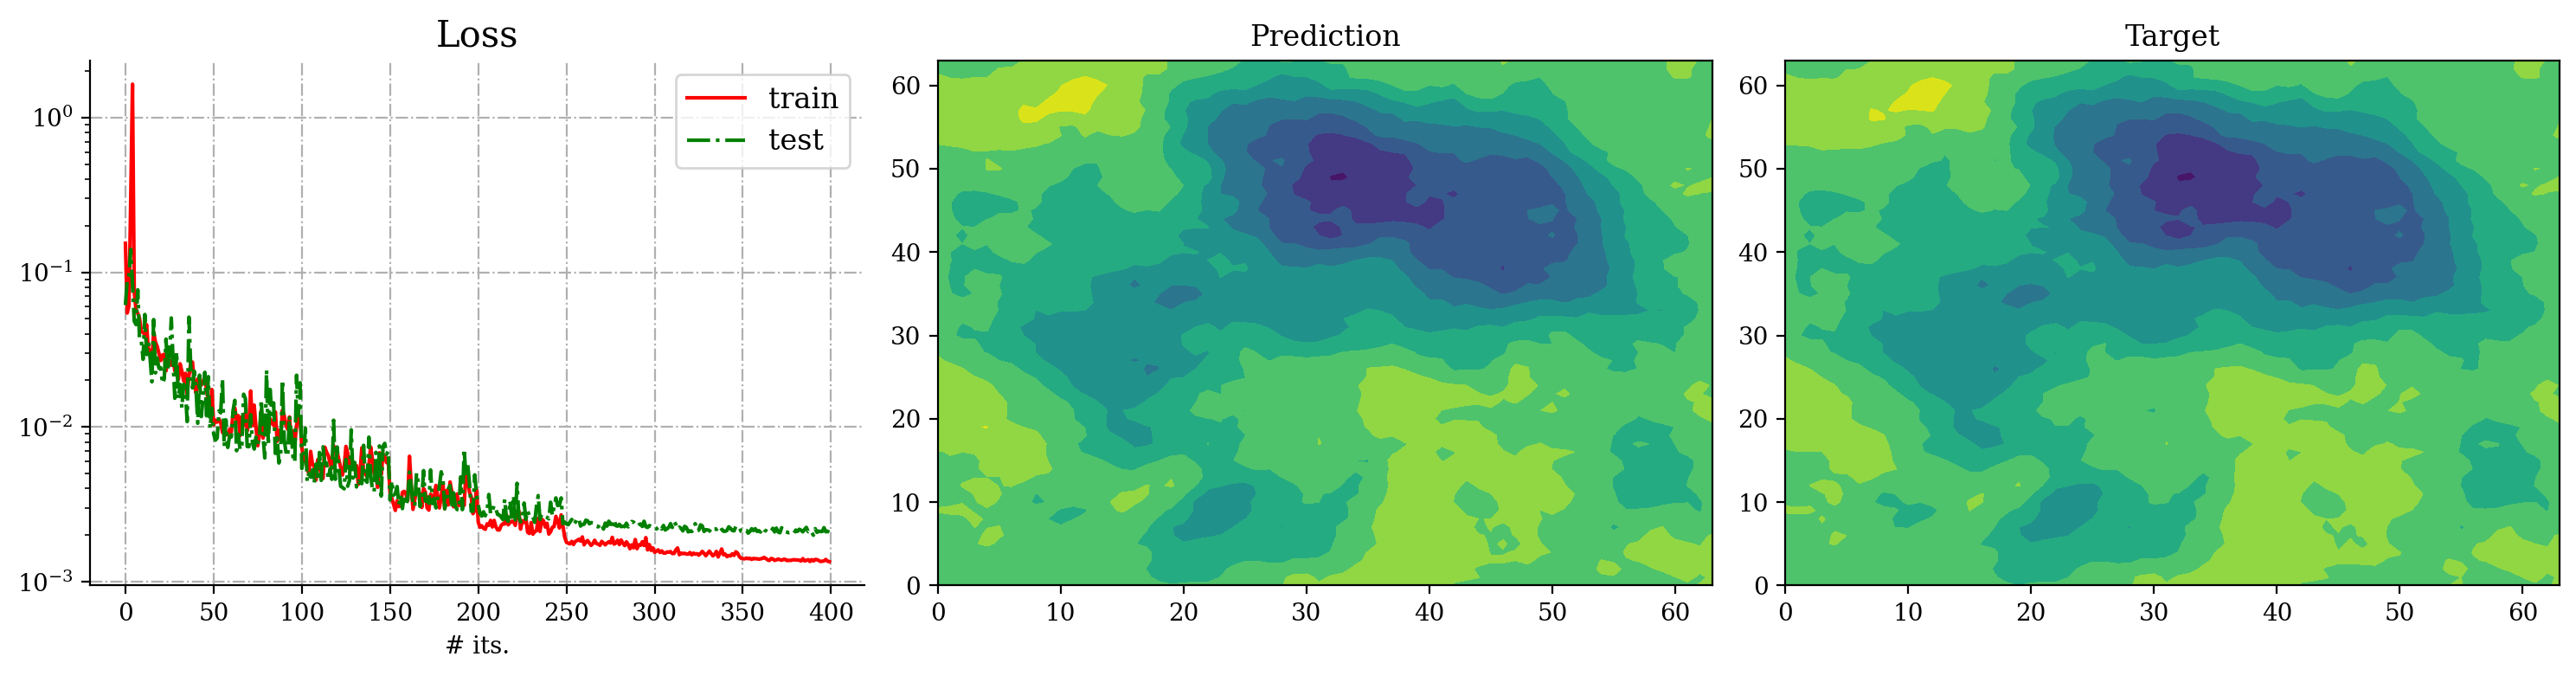

In [48]:
plot_results(model, model_data, data, features_test, targets_test)

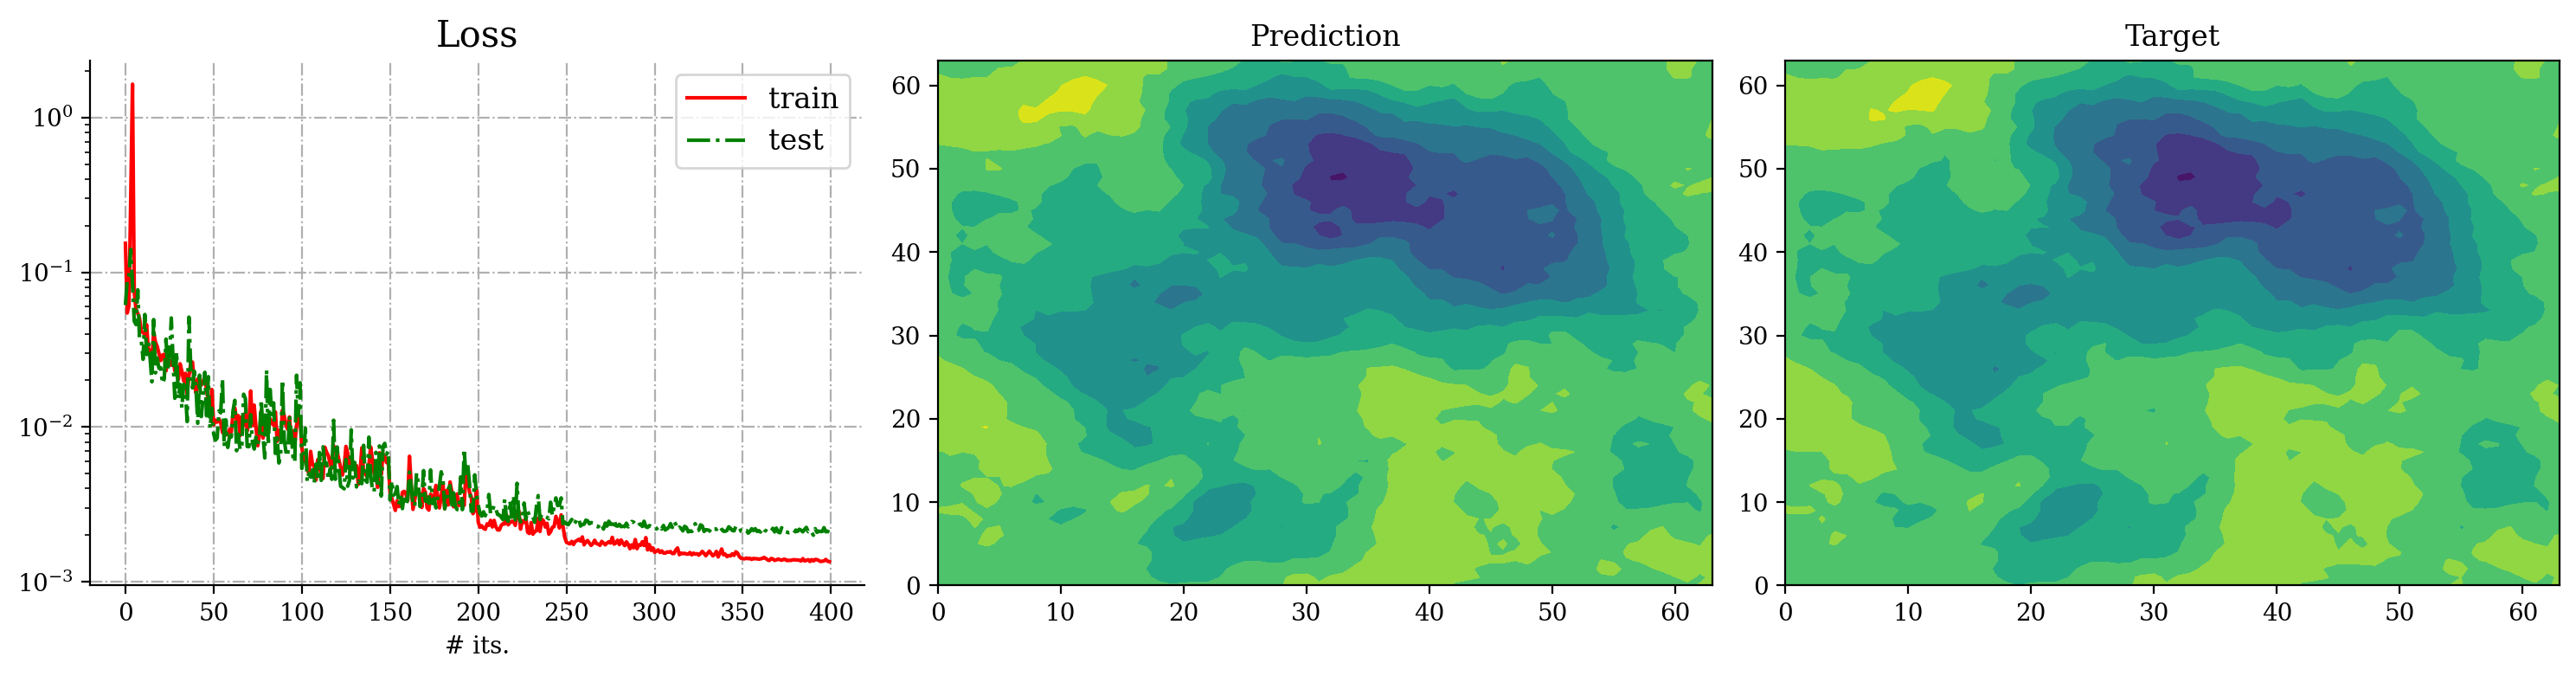

In [ ]:
import pickle
from jax.tree_util import tree_flatten


with open("unet_poisson_checkpoint.pkl", "rb") as f:
    ckpt = pickle.load(f)

loaded_model   = eqx.tree_inference(ckpt["model"])
data           = ckpt["metrics"]
features_test  = ckpt["features_test"]
targets_test   = ckpt["targets_test"]

model_data = {"model": loaded_model}

plot_results(loaded_model, model_data, data, features_test, targets_test)


In [9]:
model_size = data['model_size']
train_error_mean = jnp.round(data['train_error_mean'], 3)
test_error_mean = jnp.round(data['test_error_mean'], 3)
train_error_std = jnp.round(data['train_error_std'], 3)
test_error_std = jnp.round(data['test_error_std'], 3)

print(f'Model size: {model_size}')
print(f"Train relative error: {train_error_mean} ± {train_error_std}, \nTest relative error: {test_error_mean} ± {test_error_std}")

Model size: 1388833
Train relative error: 0.024 ± 0.011, 
Test relative error: 0.036000000000000004 ± 0.011


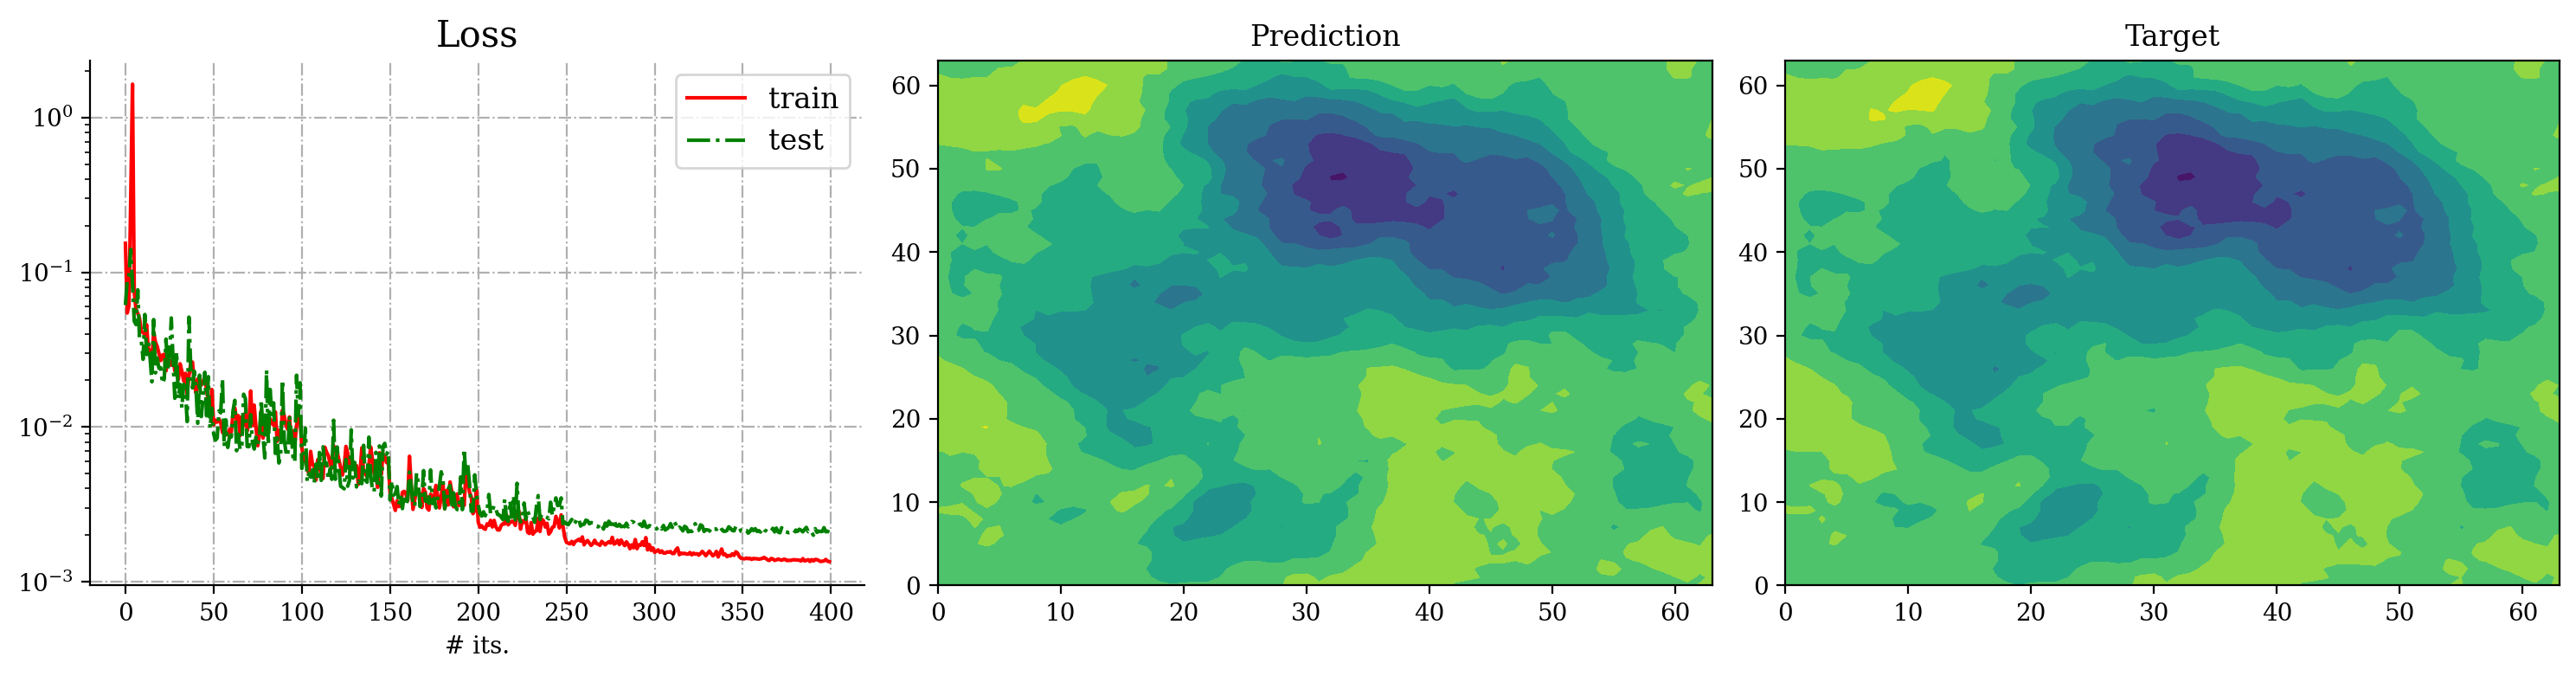

In [8]:
import pickle, hashlib, equinox as eqx, jax.numpy as jnp
from jax import vmap
from jax.tree_util import tree_flatten

def sha_model(m):
    flat, _ = tree_flatten(eqx.filter(m, eqx.is_array))
    return hashlib.md5(jnp.concatenate([jnp.ravel(a) for a in flat]).tobytes()).hexdigest()

with open("unet_poisson_checkpoint(1).pkl", "rb") as f:
    ckpt = pickle.load(f)

loaded_model  = eqx.tree_inference(ckpt["model"])       # eval-режим
assert sha_model(loaded_model) == ckpt["model_hash"], "файл повреждён"

features_test = ckpt["features_test"]
targets_test  = ckpt["targets_test"]
data          = ckpt["metrics"]

# пересчитаем относительную ошибку
def rel_err(pred, targ):
    return jnp.linalg.norm(pred.reshape(-1) - targ.reshape(-1)) / jnp.linalg.norm(targ.reshape(-1))

pred = vmap(loaded_model)(features_test)[:, 0]
err  = vmap(rel_err)(pred, targets_test[:, 0])

print("mean =", err.mean().item(), "std =", err.std().item())  # ≈ 0.02 ± 0.007

# графики, если нужны
model_data = {"model": loaded_model}
plot_results(loaded_model, model_data, data, features_test, targets_test)
